# 1.7 Data Wrangling

## 1.1. 7.1 Contents
- [7. Data Wrangling](#1-Data-Wrangling)
  - [7.1 Contents](#7.1-Contents)
  - [7.2 Imports](#7.2-Imports)
  - [7.3 Objectives](#7.3-Objectives)
  - [7.4 Load The Cost of Living Data](#7.4-Load-The-Cost-of-Living-Data)
  - [7.5 Explore The Data](#7.5-Explore-The-Data)
    - [7.5.1 Find The City Of Interest](#7.5.1-Find-The-City-Of-Interest)
    - [7.5.2 Drop The Missing Data](#7.5.2-Drop-The-Missing-Data)
    - [7.5.3 Classify Features With Similar Properties](#7.5.3-Classify-Features-With-Similar-Properties)
    - [7.5.4 Top Countries By Order Of Each Features](#7.5.4-Top-Countries-By-Order-Of-Each-Features)
    - [7.5.5 Concrate The Population Data](#7.5.5-Concrate-The-Population-Data)
  - [7.6 PCA](#7.6-PCA)
  - [7.7 Linear Model](#7.7-Linear-Model)
  - [7.8 Random Forest Model](#7.8-Random-Forest-Model)
  - [7.9 Final Model Selection](#7.9-Final-Model-Selection)
  - [7.10 Prediction](#7.10-Prediction)

## 7.2 Imports<a id='7.2_Imports'></a>

In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
import time
import pycountry
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

from library.sb_utils import save_file

## 7.3 Objectives<a id='7.3bjectives'></a>

## 7.4 Load The Cost of Living Data<a id='7.4-Load-The-Cost-of-Living_Data'></a>

In [7]:
cost_data = pd.read_csv('./data/cost-of-living_v2.csv')

In [8]:
type(cost_data)

pandas.core.frame.DataFrame

In [9]:
cost_data.head()

,city,country,x1,x2,x3,x4,x5,x6,x7,x8,...,x47,x48,x49,x50,x51,x52,x53,x54,x55,data_quality
0,Seoul,South Korea,7.68,53.78,6.15,3.07,4.99,3.93,1.48,0.79,...,110.36,742.54,557.52,2669.12,1731.08,22067.70,10971.90,2689.62,3.47,1
1,Shanghai,China,5.69,39.86,5.69,1.14,4.27,3.98,0.53,0.33,...,123.51,1091.93,569.88,2952.70,1561.59,17746.11,9416.35,1419.87,5.03,1
2,Guangzhou,China,4.13,28.47,4.98,0.85,1.71,3.54,0.44,0.33,...,43.89,533.28,317.45,1242.24,688.05,12892.82,5427.45,1211.68,5.19,1
3,Mumbai,India,3.68,18.42,3.68,2.46,4.30,2.48,0.48,0.19,...,41.17,522.40,294.05,1411.12,699.80,6092.45,2777.51,640.81,7.96,1
4,Delhi,India,4.91,22.11,4.30,1.84,3.68,1.77,0.49,0.19,...,36.50,229.84,135.31,601.02,329.15,2506.73,1036.74,586.46,8.06,1


In [10]:
cost_data.info

<bound method DataFrame.info of                     city      country     x1     x2     x3     x4    x5    x6  \
0                  Seoul  South Korea   7.68  53.78   6.15   3.07  4.99  3.93   
1               Shanghai        China   5.69  39.86   5.69   1.14  4.27  3.98   
2              Guangzhou        China   4.13  28.47   4.98   0.85  1.71  3.54   
3                 Mumbai        India   3.68  18.42   3.68   2.46  4.30  2.48   
4                  Delhi        India   4.91  22.11   4.30   1.84  3.68  1.77   
...                  ...          ...    ...    ...    ...    ...   ...   ...   
4951        Peterborough    Australia    NaN    NaN    NaN    NaN   NaN   NaN   
4952          Georgetown    Australia    NaN    NaN    NaN    NaN   NaN   NaN   
4953  Ixtapa Zihuatanejo       Mexico   5.16  30.94  12.89   0.98   NaN  1.80   
4954             Iqaluit       Canada  29.65  74.27  13.71   6.67  8.89  3.71   
4955              Neiafu        Tonga    NaN  29.79  10.64  10.64   NaN   NaN

I noticed that some column names were like `x1`, `x2`, etc., so I downloaded another CSV file `column_names` that contains the specific column names. I used the column values from that table to rename the columns of `cost_data`.

In [12]:
df_columns = pd.read_csv('./data/column_names1.csv')
df_columns.head()

,city,city.1
0,country,country
1,x1,Meal_Inexpensive
2,x2,Meal_for_2 People
3,x3,McMeal_McDonalds
4,x4,Domestic_Beer_Restaurant


In [13]:
columns_only = pd.DataFrame([df_columns.columns], columns=df_columns.columns)
df_columns_new = pd.concat([columns_only, df_columns], ignore_index=True)
df_columns_new.columns = range(df_columns_new.shape[1])
df_columns_new.iloc[0, 1] = 'city'
df_columns_new.head()

,0,1
0,city,city
1,country,country
2,x1,Meal_Inexpensive
3,x2,Meal_for_2 People
4,x3,McMeal_McDonalds


In [14]:
rename_dict = dict(zip(df_columns_new[0], df_columns_new[1]))              

In [15]:
cost_data_named = cost_data.rename(columns=rename_dict)
print(cost_data_named.head())

        city      country  Meal_Inexpensive  Meal_for_2 People  \
0      Seoul  South Korea              7.68              53.78   
1   Shanghai        China              5.69              39.86   
2  Guangzhou        China              4.13              28.47   
3     Mumbai        India              3.68              18.42   
4      Delhi        India              4.91              22.11   

   McMeal_McDonalds  Domestic_Beer_Restaurant  Imported_Beer_Restaurant  \
0              6.15                      3.07                      4.99   
1              5.69                      1.14                      4.27   
2              4.98                      0.85                      1.71   
3              3.68                      2.46                      4.30   
4              4.30                      1.84                      3.68   

   Cappuccino  Coke/Pepsi  Water_Restaurant  ...  Leather_Shoes  \
0        3.93        1.48              0.79  ...         110.36   
1        3.98     

## 7.5 Explore The Data<a id='7.5-Explore_The_Data'></a>

### 7.5.1 Find The City Of Interest<a id='7.5.1-Find-The-City-Of-Interest'></a>

My city of interest is called Portland. Check it's in the data:

In [19]:
cost_data_named[(cost_data_named.city == 'Portland') & (cost_data_named.country == 'United States')].T

,229
city,Portland
country,United States
Meal_Inexpensive,16.75
Meal_for_2 People,75.0
McMeal_McDonalds,8.75
Domestic_Beer_Restaurant,6.0
Imported_Beer_Restaurant,7.0
Cappuccino,5.01
Coke/Pepsi,2.44
Water_Restaurant,2.05


### 7.5.2 Drop The Missing Data<a id='7.5.2-Drop-The-Missing-Data'></a>

In [21]:
missing = pd.concat([cost_data_named.isnull().sum(), cost_data_named.isnull().mean() * 100], axis=1, ignore_index=True)
missing.columns = ['count', '%']
missing.sort_values(by='%', ascending=True)
missing

,count,%
city,0,0.000000
country,0,0.000000
Meal_Inexpensive,428,8.635997
Meal_for_2 People,451,9.100081
McMeal_McDonalds,334,6.739306
Domestic_Beer_Restaurant,496,10.008071
Imported_Beer_Restaurant,440,8.878128
Cappuccino,344,6.941082
Coke/Pepsi,445,8.979015
Water_Restaurant,316,6.376110


### 7.5.3 Classify Features With Similar Properties<a id='7.5.3-Classify-Features-With-Similar-Properties'></a>

In [23]:
cost_data_named_no_null = cost_data_named.dropna()

In [24]:
cost_data_named_no_null.shape

(1278, 58)

In [25]:
cost_data_no_null = cost_data.dropna()

In [26]:
cost_data_no_null.shape

(1278, 58)

In [27]:
def optimized_df(df, mapping):
    df_optimized = pd.DataFrame(index=df.index)
    for new_col, original_col in mapping.items():
        df_optimized[new_col] = df[original_col].mean(axis=1)
    df = pd.concat([df.iloc[:, :2], df_optimized], axis=1)
    return df

In [28]:
mapping_column = {'eating_out': ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8'],
                     'groceries': ['x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27'],
                     'transport': ['x28','x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35'],
                     'utilities': ['x36', 'x37', 'x38'],
                     'sports_leisure': ['x39', 'x40', 'x41'],
                     'childcare_education': ['x42', 'x43'],
                     'clothing': ['x44', 'x45', 'x46', 'x47'],
                     'rent': ['x48', 'x49', 'x50', 'x51'],
                     'house_price': ['x52', 'x53'],
                     'mortgage': ['x55'],
                     'income': ['x54']
                    }
                      

In [29]:
df_categorized = optimized_df(cost_data_no_null, mapping_column)

In [30]:
df_categorized.reset_index(drop=True, inplace=True)

In [31]:
df_categorized

,city,country,eating_out,groceries,transport,utilities,sports_leisure,childcare_education,clothing,rent,house_price,mortgage,income
0,Seoul,South Korea,10.23375,7.004211,7136.35500,68.256667,27.936667,9153.350,71.4475,1425.0650,16519.800,3.47,2689.62
1,Shanghai,China,7.68625,4.040000,5090.24750,27.700000,28.993333,13881.035,79.2825,1544.0250,13581.230,5.03,1419.87
2,Guangzhou,China,5.55625,3.075263,5346.66125,25.443333,20.563333,12555.695,51.9700,695.2550,9160.135,5.19,1211.68
3,Mumbai,India,4.46125,2.375263,4385.07500,17.636667,13.686667,1894.870,37.8900,731.8425,4434.980,7.96,640.81
4,Delhi,India,4.91125,2.166316,4404.73375,22.010000,11.570000,1019.120,38.0125,323.8300,1771.735,8.06,586.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273,Gig Harbor,United States,10.64125,5.238421,6304.27625,95.933333,44.666667,9900.835,72.1050,2300.0000,3336.815,5.23,4500.00
1274,Lysa nad Labem,Czech Republic,6.22750,2.597368,8115.35875,195.490000,25.740000,2379.225,65.7600,613.7325,2162.930,7.00,634.46
1275,Murovani Kurylivtsi,Ukraine,2.56000,1.544737,4030.00375,24.353333,4.600000,777.365,45.4800,122.3850,234.570,13.05,365.79
1276,Tirupati,India,2.91500,2.220000,3379.56000,11.896667,11.190000,632.515,30.3725,114.3750,528.800,7.97,614.09


In [32]:
(df_categorized['city'] + ',' + df_categorized['country']).value_counts().head()

Seoul,South Korea     1
Teresopolis,Brazil    1
Livorno,Italy         1
Heidelberg,Germany    1
Arad,Romania          1
Name: count, dtype: int64

### 7.5.4 Top Countries By Order Of Each Features<a id='7.5.4-Top-Countries-By-Order-Of-Each-Features'></a>

In [34]:
country_avg_income = df_categorized.groupby('country')['income'].mean().reset_index(name='avg_monthly_income')

In [35]:
country_avg_income

,country,avg_monthly_income
0,Albania,427.102000
1,Algeria,254.927500
2,Angola,1428.770000
3,Argentina,406.863333
4,Armenia,526.470000
...,...,...
145,Uruguay,796.370000
146,Uzbekistan,277.322500
147,Venezuela,195.040000
148,Vietnam,508.762000


Text(0, 0.5, 'Count')

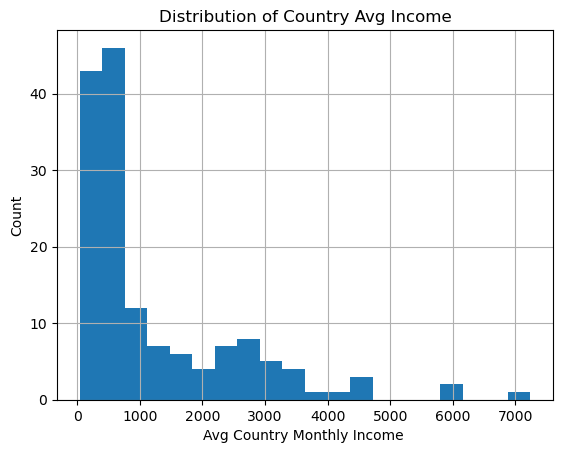

In [36]:
country_avg_income.hist(bins=20)
plt.title('Distribution of Country Avg Income')
plt.xlabel('Avg Country Monthly Income ')
plt.ylabel('Count')

In [37]:
country_avg_income.sort_values(by='avg_monthly_income', ascending=False).head(10)

,country,avg_monthly_income
76,Liechtenstein,7241.720000
129,Switzerland,6043.583636
13,Bermuda,5973.810000
118,Singapore,4619.450000
59,Isle Of Man,4608.500000
144,United States,4547.008462
78,Luxembourg,4272.110000
5,Australia,3786.154667
100,Norway,3580.589000
46,Gibraltar,3385.920000


Those are TOP 10 high income cities.

HAI(House Affordablity Index) = house_price / income.

In [39]:
HAI = df_categorized['house_price'] / df_categorized['income']
HAI

0       6.142057
1       9.565122
2       7.559863
3       6.920897
4       3.021067
          ...   
1273    0.741514
1274    3.409088
1275    0.641270
1276    0.861112
1277    0.764284
Length: 1278, dtype: float64

In [40]:
df_categorized['HAI'] = HAI

In [243]:
average_house_price_m2 = df_categorized['house_price'].mean()
average_house_price_m2

2894.865865309319

In [41]:
df_categorized.head()

,city,country,eating_out,groceries,transport,utilities,sports_leisure,childcare_education,clothing,rent,house_price,mortgage,income,HAI
0,Seoul,South Korea,10.23375,7.004211,7136.35500,68.256667,27.936667,9153.350,71.4475,1425.0650,16519.800,3.47,2689.62,6.142057
1,Shanghai,China,7.68625,4.040000,5090.24750,27.700000,28.993333,13881.035,79.2825,1544.0250,13581.230,5.03,1419.87,9.565122
2,Guangzhou,China,5.55625,3.075263,5346.66125,25.443333,20.563333,12555.695,51.9700,695.2550,9160.135,5.19,1211.68,7.559863
3,Mumbai,India,4.46125,2.375263,4385.07500,17.636667,13.686667,1894.870,37.8900,731.8425,4434.980,7.96,640.81,6.920897
4,Delhi,India,4.91125,2.166316,4404.73375,22.010000,11.570000,1019.120,38.0125,323.8300,1771.735,8.06,586.46,3.021067


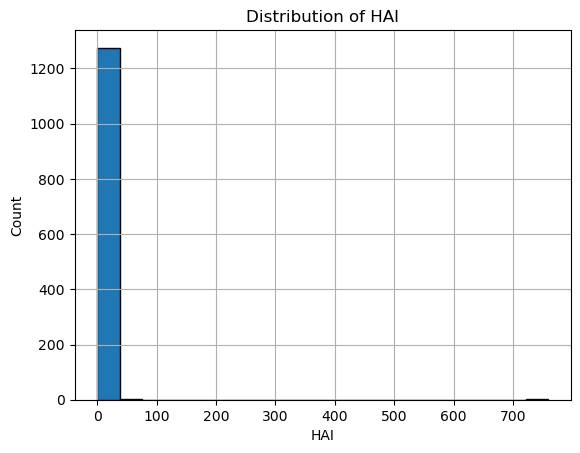

In [42]:
df_categorized['HAI'].hist(bins=20, edgecolor='black')  # bins可自行调整，例如20、30等
plt.xlabel("HAI")
plt.ylabel("Count")
plt.title("Distribution of HAI")
plt.show()

In [43]:
df_categorized[df_categorized['HAI'] > 600]

,city,country,eating_out,groceries,transport,utilities,sports_leisure,childcare_education,clothing,rent,house_price,mortgage,income,HAI
298,Niamey,Niger,6.8125,3.288947,2917.0875,128.996667,16.066667,2864.79,41.5,500.3975,160642.445,11.0,211.51,759.502837


Drop the outlier value.

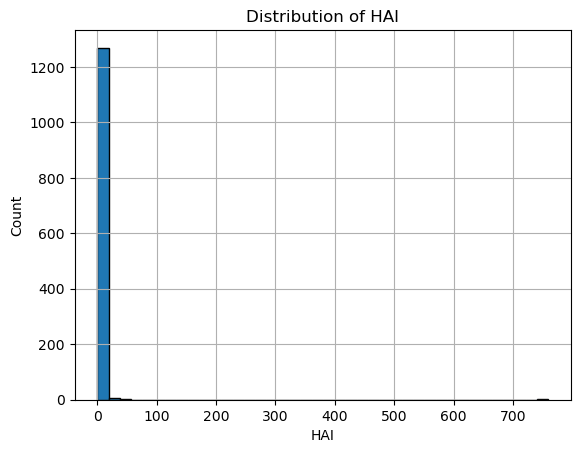

In [44]:
df_categorized['HAI'].hist(bins=40, edgecolor='black')  # bins可自行调整，例如20、30等
plt.xlabel("HAI")
plt.ylabel("Count")
plt.title("Distribution of HAI")
plt.show()

In [45]:
df_categorized = df_categorized[df_categorized['HAI'] < 600]

Find the city I interest

In [46]:
df_categorized[df_categorized['city'] == 'Portland']

,city,country,eating_out,groceries,transport,utilities,sports_leisure,childcare_education,clothing,rent,house_price,mortgage,income,HAI
160,Portland,United States,15.375,6.048947,6782.2575,93.25,30.84,9886.605,86.0125,2224.445,4295.1,5.14,4599.72,0.933774


In [48]:
df_categorized

,city,country,eating_out,groceries,transport,utilities,sports_leisure,childcare_education,clothing,rent,house_price,mortgage,income,HAI
0,Seoul,South Korea,10.23375,7.004211,7136.35500,68.256667,27.936667,9153.350,71.4475,1425.0650,16519.800,3.47,2689.62,6.142057
1,Shanghai,China,7.68625,4.040000,5090.24750,27.700000,28.993333,13881.035,79.2825,1544.0250,13581.230,5.03,1419.87,9.565122
2,Guangzhou,China,5.55625,3.075263,5346.66125,25.443333,20.563333,12555.695,51.9700,695.2550,9160.135,5.19,1211.68,7.559863
3,Mumbai,India,4.46125,2.375263,4385.07500,17.636667,13.686667,1894.870,37.8900,731.8425,4434.980,7.96,640.81,6.920897
4,Delhi,India,4.91125,2.166316,4404.73375,22.010000,11.570000,1019.120,38.0125,323.8300,1771.735,8.06,586.46,3.021067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273,Gig Harbor,United States,10.64125,5.238421,6304.27625,95.933333,44.666667,9900.835,72.1050,2300.0000,3336.815,5.23,4500.00,0.741514
1274,Lysa nad Labem,Czech Republic,6.22750,2.597368,8115.35875,195.490000,25.740000,2379.225,65.7600,613.7325,2162.930,7.00,634.46,3.409088
1275,Murovani Kurylivtsi,Ukraine,2.56000,1.544737,4030.00375,24.353333,4.600000,777.365,45.4800,122.3850,234.570,13.05,365.79,0.641270
1276,Tirupati,India,2.91500,2.220000,3379.56000,11.896667,11.190000,632.515,30.3725,114.3750,528.800,7.97,614.09,0.861112


In [49]:
!pip install geopandas

In [50]:
df_country = df_categorized.groupby('country')['HAI'].mean()

In [51]:
df_country.sort_values(ascending=False)

country
Papua New Guinea    36.463394
Gabon               32.173704
Rwanda              28.497961
Botswana            27.686073
Syria               25.789357
                      ...    
Liechtenstein        0.669762
South Africa         0.635359
Saudi Arabia         0.536853
Isle Of Man          0.433709
Swaziland            0.256098
Name: HAI, Length: 149, dtype: float64

### 7.5.5 Concrate The Population Data<a id='7.5.4-Concrate-The-Population Data'></a>

In [52]:
!pip install pycountry

In [53]:
code_dict = {}

for country in pycountry.countries:
    code_dict[country.name] = country.alpha_2

data = []
for country in pycountry.countries:
    data.append({
        "name": country.name,
        "code": country.alpha_2
    })

df_code = pd.DataFrame(data)

In [54]:
df_code

,name,code
0,Aruba,AW
1,Afghanistan,AF
2,Angola,AO
3,Anguilla,AI
4,Åland Islands,AX
...,...,...
244,Samoa,WS
245,Yemen,YE
246,South Africa,ZA
247,Zambia,ZM


In [55]:
df_code[df_code["name"].str.contains("China")]

,name,code
43,China,CN
228,"Taiwan, Province of China",TW


In [56]:
df_categorized[df_categorized["country"].str.contains('China')]

,city,country,eating_out,groceries,transport,utilities,sports_leisure,childcare_education,clothing,rent,house_price,mortgage,income,HAI
1,Shanghai,China,7.68625,4.040000,5090.24750,27.700000,28.993333,13881.035,79.2825,1544.0250,13581.230,5.03,1419.87,9.565122
2,Guangzhou,China,5.55625,3.075263,5346.66125,25.443333,20.563333,12555.695,51.9700,695.2550,9160.135,5.19,1211.68,7.559863
8,Shenzhen,China,5.98250,3.780000,5287.55500,28.626667,24.386667,12002.770,72.1675,935.5700,12995.150,4.99,1572.22,8.265478
17,Beijing,China,6.54875,3.604737,5838.13875,25.503333,32.130000,14149.440,79.8950,1527.7350,13703.260,4.94,1562.35,8.770928
27,Chengdu,China,5.14000,3.341579,5178.14375,15.696667,20.030000,9674.195,74.7400,488.7525,3028.175,5.08,802.58,3.773051
29,Wuhan,China,5.43750,3.455789,4228.78125,18.396667,18.460000,11803.590,73.1675,449.6625,2932.890,4.99,963.86,3.042859
38,Tianjin,China,5.87375,3.230526,4807.67750,29.253333,21.356667,4962.845,62.8025,580.3950,4567.480,5.20,875.36,5.217830
39,Zhengzhou,China,3.81750,3.160000,5440.59125,20.896667,30.766667,2633.565,76.3350,320.3000,2264.850,5.47,586.03,3.864734
43,Chongqing,China,4.11375,2.720000,4787.44750,18.950000,13.203333,10854.560,45.9800,298.7850,2307.165,5.33,747.36,3.087087
46,Foshan,China,4.47000,3.240526,5340.17500,22.166667,27.640000,12555.695,40.0075,400.7275,3974.075,5.19,960.90,4.135784


In [57]:
def fuzzy_search(country_name):
    if not isinstance(country_name, str):
        return None
    try:
        result = pycountry.countries.search_fuzzy(country_name)[0]
        return result.alpha_2
    except LookupError:
        return None
    

In [58]:
df_categorized['country_code'] = df_categorized['country'].apply(fuzzy_search)
df_categorized

C:\Users\brigi\AppData\Local\Temp\ipykernel_52236\217318396.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_categorized['country_code'] = df_categorized['country'].apply(fuzzy_search)


,city,country,eating_out,groceries,transport,utilities,sports_leisure,childcare_education,clothing,rent,house_price,mortgage,income,HAI,country_code
0,Seoul,South Korea,10.23375,7.004211,7136.35500,68.256667,27.936667,9153.350,71.4475,1425.0650,16519.800,3.47,2689.62,6.142057,KR
1,Shanghai,China,7.68625,4.040000,5090.24750,27.700000,28.993333,13881.035,79.2825,1544.0250,13581.230,5.03,1419.87,9.565122,CN
2,Guangzhou,China,5.55625,3.075263,5346.66125,25.443333,20.563333,12555.695,51.9700,695.2550,9160.135,5.19,1211.68,7.559863,CN
3,Mumbai,India,4.46125,2.375263,4385.07500,17.636667,13.686667,1894.870,37.8900,731.8425,4434.980,7.96,640.81,6.920897,IN
4,Delhi,India,4.91125,2.166316,4404.73375,22.010000,11.570000,1019.120,38.0125,323.8300,1771.735,8.06,586.46,3.021067,IN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273,Gig Harbor,United States,10.64125,5.238421,6304.27625,95.933333,44.666667,9900.835,72.1050,2300.0000,3336.815,5.23,4500.00,0.741514,US
1274,Lysa nad Labem,Czech Republic,6.22750,2.597368,8115.35875,195.490000,25.740000,2379.225,65.7600,613.7325,2162.930,7.00,634.46,3.409088,CZ
1275,Murovani Kurylivtsi,Ukraine,2.56000,1.544737,4030.00375,24.353333,4.600000,777.365,45.4800,122.3850,234.570,13.05,365.79,0.641270,UA
1276,Tirupati,India,2.91500,2.220000,3379.56000,11.896667,11.190000,632.515,30.3725,114.3750,528.800,7.97,614.09,0.861112,IN


In [59]:
df_categorized[['city', 'country', 'country_code', 'HAI']]

,city,country,country_code,HAI
0,Seoul,South Korea,KR,6.142057
1,Shanghai,China,CN,9.565122
2,Guangzhou,China,CN,7.559863
3,Mumbai,India,IN,6.920897
4,Delhi,India,IN,3.021067
...,...,...,...,...
1273,Gig Harbor,United States,US,0.741514
1274,Lysa nad Labem,Czech Republic,CZ,3.409088
1275,Murovani Kurylivtsi,Ukraine,UA,0.641270
1276,Tirupati,India,IN,0.861112


In [60]:
df_pop = pd.read_csv('cities15000.txt', sep='\t', header=None)

In [61]:
df_pop.sort_values(by=14, ascending=False).head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
4462,1796236,Shanghai,Shanghai,"SHA,San'nkae,Sanchajus,Sangaj,Sangay,Sanghaj,S...",31.22222,121.45806,P,PPLA,CN,NaN,23,12324204,NaN,NaN,22315474,NaN,12,Asia/Shanghai,2024-09-05
5098,1816670,Beijing,Beijing,"BJS,Bac Kinh,Baek-ging,Baekging,Behehzhin,Beij...",39.90750,116.39723,P,PPLC,CN,NaN,22,11876380,NaN,NaN,18960744,NaN,49,Asia/Shanghai,2024-12-12
4439,1795565,Shenzhen,Shenzhen,"Bao'an,Chhum-chun-su,Chhṳ̂m-chun-sṳ,Pao-an,Pao...",22.54554,114.06830,P,PPLA2,CN,NaN,30,4403,NaN,NaN,17494398,NaN,4,Asia/Shanghai,2024-05-16
4910,1809858,Guangzhou,Guangzhou,"CAN,Cantao,Canton,Cantão,Cantón,Fan-yu,Fan-yü,...",23.11667,113.25000,P,PPLA,CN,NaN,30,4401,NaN,NaN,16096724,NaN,15,Asia/Shanghai,2024-03-27
3386,2314302,Kinshasa,Kinshasa,"FIH,Kincasa,Kinchasa,Kinchassa,Kinsas,Kinsasa,...",-4.32758,15.31357,P,PPLC,CD,NaN,06,00,NaN,NaN,16000000,NaN,281,Africa/Kinshasa,2023-11-29


In [62]:
df_pop = df_pop.rename(columns={1: "city", 8: "country_code", 14: "population"})
df_pop.head()

,0,city,2,3,4,5,6,7,country_code,9,10,11,12,13,population,15,16,17,18
0,3040051,les Escaldes,les Escaldes,"Ehskal'des-Ehndzhordani,Escaldes,Escaldes-Engo...",42.50729,1.53414,P,PPLA,AD,NaN,08,NaN,NaN,NaN,15853,NaN,1033,Europe/Andorra,2024-06-20
1,3041563,Andorra la Vella,Andorra la Vella,"ALV,Ando-la-Vyey,Andora,Andora la Vela,Andora ...",42.50779,1.52109,P,PPLC,AD,NaN,07,NaN,NaN,NaN,20430,NaN,1037,Europe/Andorra,2020-03-03
2,290503,Warīsān,Warisan,"Warisan,Warsan,Warīsān,wrsan,ورسان",25.16744,55.40708,P,PPL,AE,NaN,03,NaN,NaN,NaN,108759,NaN,12,Asia/Dubai,2024-06-11
3,290581,Umm Suqaym,Umm Suqaym,"Umm Suqaym,Umm Suqeim,Umm Suqeim 2,Umm as Suqa...",25.15491,55.21015,P,PPLX,AE,NaN,03,NaN,NaN,NaN,16459,NaN,1,Asia/Dubai,2024-10-28
4,290594,Umm Al Quwain City,Umm Al Quwain City,"Oumm al Qaiwain,Oumm al Qaïwaïn,Um al Kawain,U...",25.56473,55.55517,P,PPLA,AE,NaN,07,NaN,NaN,NaN,62747,NaN,2,Asia/Dubai,2019-10-24


In [63]:
df_merged = df_categorized.merge(
    df_pop[['city', 'country_code', 'population']],
    how = 'left',
    on=['city', 'country_code']
)
df_merged

,city,country,eating_out,groceries,transport,utilities,sports_leisure,childcare_education,clothing,rent,house_price,mortgage,income,HAI,country_code,population
0,Seoul,South Korea,10.23375,7.004211,7136.35500,68.256667,27.936667,9153.350,71.4475,1425.0650,16519.800,3.47,2689.62,6.142057,KR,10349312.0
1,Shanghai,China,7.68625,4.040000,5090.24750,27.700000,28.993333,13881.035,79.2825,1544.0250,13581.230,5.03,1419.87,9.565122,CN,22315474.0
2,Guangzhou,China,5.55625,3.075263,5346.66125,25.443333,20.563333,12555.695,51.9700,695.2550,9160.135,5.19,1211.68,7.559863,CN,16096724.0
3,Mumbai,India,4.46125,2.375263,4385.07500,17.636667,13.686667,1894.870,37.8900,731.8425,4434.980,7.96,640.81,6.920897,IN,12691836.0
4,Delhi,India,4.91125,2.166316,4404.73375,22.010000,11.570000,1019.120,38.0125,323.8300,1771.735,8.06,586.46,3.021067,IN,11034555.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,Gig Harbor,United States,10.64125,5.238421,6304.27625,95.933333,44.666667,9900.835,72.1050,2300.0000,3336.815,5.23,4500.00,0.741514,US,NaN
1354,Lysa nad Labem,Czech Republic,6.22750,2.597368,8115.35875,195.490000,25.740000,2379.225,65.7600,613.7325,2162.930,7.00,634.46,3.409088,CZ,NaN
1355,Murovani Kurylivtsi,Ukraine,2.56000,1.544737,4030.00375,24.353333,4.600000,777.365,45.4800,122.3850,234.570,13.05,365.79,0.641270,UA,NaN
1356,Tirupati,India,2.91500,2.220000,3379.56000,11.896667,11.190000,632.515,30.3725,114.3750,528.800,7.97,614.09,0.861112,IN,295323.0


In [64]:
df_merged.shape

(1358, 16)

In [65]:
df_dedup = df_merged.sort_values('population', ascending=False).drop_duplicates(['city', 'country_code'], keep='first')
df_dedup.shape

(1277, 16)

In [66]:
df_dedup[['country_code', 'population']].isnull().sum()

country_code     28
population      296
dtype: int64

In [67]:
df_nonull = df_dedup.dropna()

In [68]:
df_nonull

,city,country,eating_out,groceries,transport,utilities,sports_leisure,childcare_education,clothing,rent,house_price,mortgage,income,HAI,country_code,population
1,Shanghai,China,7.68625,4.040000,5090.24750,27.700000,28.993333,13881.035,79.2825,1544.0250,13581.230,5.03,1419.87,9.565122,CN,22315474.0
17,Beijing,China,6.54875,3.604737,5838.13875,25.503333,32.130000,14149.440,79.8950,1527.7350,13703.260,4.94,1562.35,8.770928,CN,18960744.0
8,Shenzhen,China,5.98250,3.780000,5287.55500,28.626667,24.386667,12002.770,72.1675,935.5700,12995.150,4.99,1572.22,8.265478,CN,17494398.0
2,Guangzhou,China,5.55625,3.075263,5346.66125,25.443333,20.563333,12555.695,51.9700,695.2550,9160.135,5.19,1211.68,7.559863,CN,16096724.0
15,Lagos,Nigeria,7.81000,2.777368,6590.70375,27.046667,19.173333,1522.795,45.8525,2325.6000,523.855,17.50,214.64,2.440622,NG,15388000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346,Baden,Switzerland,24.79000,8.941579,7877.82000,108.143333,59.323333,11752.955,111.4125,1489.1525,10951.615,1.44,5374.09,2.037855,CH,16118.0
1344,Albufeira,Portugal,9.36125,2.611053,8108.59875,75.466667,19.803333,3371.985,79.9300,970.6200,2185.730,2.00,895.68,2.440302,PT,15851.0
393,Valletta,Malta,15.85750,4.414211,5058.07000,71.083333,39.663333,5286.115,122.5000,1474.8775,7499.155,4.67,1184.80,6.329469,MT,6794.0
394,Vaduz,Liechtenstein,21.68000,6.208947,8332.85250,83.046667,41.133333,6659.115,96.6500,1813.3275,4850.230,7.12,7241.72,0.669762,LI,5197.0


In [137]:
!pip install scikit-learn

In [139]:
!pip install seaborn

In [147]:
df = df_nonull.drop('country_code', axis=1)
df

,city,country,eating_out,groceries,transport,utilities,sports_leisure,childcare_education,clothing,rent,house_price,mortgage,income,HAI,population
1,Shanghai,China,7.68625,4.040000,5090.24750,27.700000,28.993333,13881.035,79.2825,1544.0250,13581.230,5.03,1419.87,9.565122,22315474.0
17,Beijing,China,6.54875,3.604737,5838.13875,25.503333,32.130000,14149.440,79.8950,1527.7350,13703.260,4.94,1562.35,8.770928,18960744.0
8,Shenzhen,China,5.98250,3.780000,5287.55500,28.626667,24.386667,12002.770,72.1675,935.5700,12995.150,4.99,1572.22,8.265478,17494398.0
2,Guangzhou,China,5.55625,3.075263,5346.66125,25.443333,20.563333,12555.695,51.9700,695.2550,9160.135,5.19,1211.68,7.559863,16096724.0
15,Lagos,Nigeria,7.81000,2.777368,6590.70375,27.046667,19.173333,1522.795,45.8525,2325.6000,523.855,17.50,214.64,2.440622,15388000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346,Baden,Switzerland,24.79000,8.941579,7877.82000,108.143333,59.323333,11752.955,111.4125,1489.1525,10951.615,1.44,5374.09,2.037855,16118.0
1344,Albufeira,Portugal,9.36125,2.611053,8108.59875,75.466667,19.803333,3371.985,79.9300,970.6200,2185.730,2.00,895.68,2.440302,15851.0
393,Valletta,Malta,15.85750,4.414211,5058.07000,71.083333,39.663333,5286.115,122.5000,1474.8775,7499.155,4.67,1184.80,6.329469,6794.0
394,Vaduz,Liechtenstein,21.68000,6.208947,8332.85250,83.046667,41.133333,6659.115,96.6500,1813.3275,4850.230,7.12,7241.72,0.669762,5197.0


## 7.6 PCA<a id='7.6_PCA'></a>

In [175]:
df_set = df.set_index(['city', 'country'])
df_index = df_set.index
df_columns = df_set.columns
df_set.head()

,,eating_out,groceries,transport,utilities,sports_leisure,childcare_education,clothing,rent,house_price,mortgage,income,HAI,population
city,country,,,,,,,,,,,,,
Shanghai,China,7.68625,4.040000,5090.24750,27.700000,28.993333,13881.035,79.2825,1544.025,13581.230,5.03,1419.87,9.565122,22315474.0
Beijing,China,6.54875,3.604737,5838.13875,25.503333,32.130000,14149.440,79.8950,1527.735,13703.260,4.94,1562.35,8.770928,18960744.0
Shenzhen,China,5.98250,3.780000,5287.55500,28.626667,24.386667,12002.770,72.1675,935.570,12995.150,4.99,1572.22,8.265478,17494398.0
Guangzhou,China,5.55625,3.075263,5346.66125,25.443333,20.563333,12555.695,51.9700,695.255,9160.135,5.19,1211.68,7.559863,16096724.0
Lagos,Nigeria,7.81000,2.777368,6590.70375,27.046667,19.173333,1522.795,45.8525,2325.600,523.855,17.50,214.64,2.440622,15388000.0


In [179]:
df_scale = scale(df_set)

In [183]:
df_pca = PCA().fit(df_scale)

Text(0.5, 1.0, 'Cumulative variance ratio explained by PCA components for life cost')

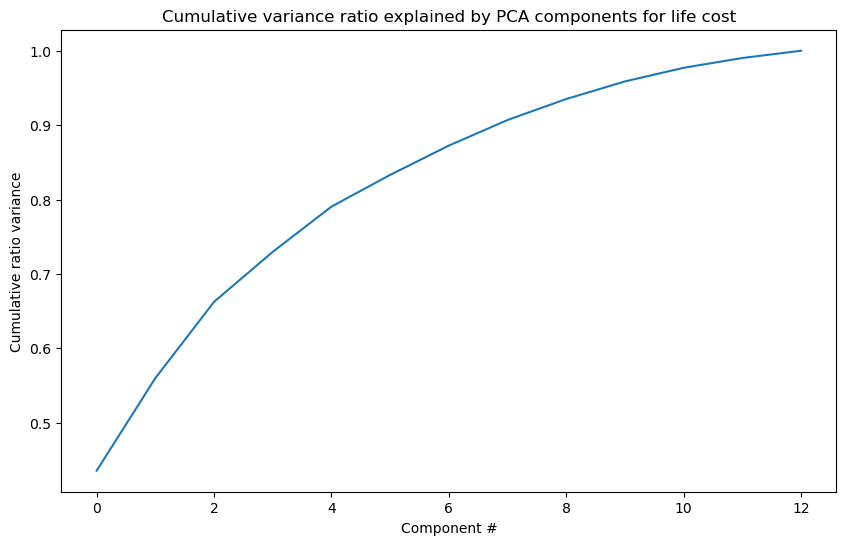

In [185]:
plt.subplots(figsize=(10, 6))
plt.plot(df_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for life cost')

The first 4 components seem to account for over 80% of the variance, and the first 10 for over 95%.

## 7.7 Linear Model<a id='7.7-Linear_Model'></a>

In [201]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_set.drop(columns='house_price'), 
                                                    df.house_price, test_size=0.3, 
                                                    random_state=47)

In [279]:
pipe = make_pipeline(
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [281]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x000001D72B0C7BA0>)),
                ('linearregression', LinearRegression())])

In [283]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [285]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.6997141687267313, 0.4206099769834274)

In [287]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(1000.6812449320523, 1344.6744558892947)

In [289]:
cv_results = cross_validate(pipe, X_train, y_train, cv=5)

In [269]:
cv_scores = cv_results['test_score']
cv_scores

array([0.70303536, 0.62569711, 0.75960188, 0.68647543, 0.68884063])

In [291]:
np.mean(cv_scores), np.std(cv_scores)

(0.6927300834494875, 0.042721666118133224)

In [277]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'linearregression', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__positive'])

In [293]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [295]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [297]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001D72B0C7BA0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12]})

In [299]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [301]:
lr_grid_cv.best_params_

{'selectkbest__k': 12}

Text(0.5, 1.0, 'Pipeline mean CV score (error bars +/- 1sd)')

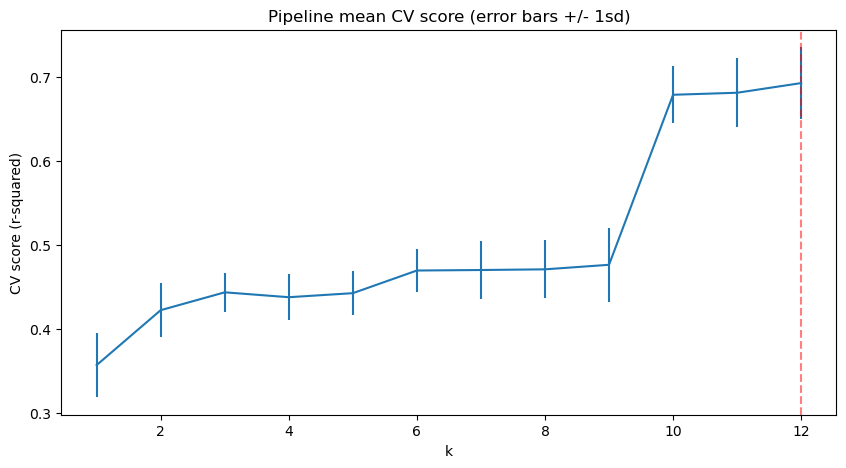

In [309]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)')

## 7.8 Random Forest Model<a id='7.8-Random_Forest_Model'></a>

In [317]:
RF_pipe = make_pipeline(    
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

In [319]:
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [321]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.87373949, 0.86660755, 0.89585746, 0.85109007, 0.84106753])

In [323]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.8656724205228276, 0.018948006868038943)

In [331]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None]}

In [333]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [335]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'standardscaler': [StandardScaler(), None]})

In [337]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 615, 'standardscaler': None}

In [339]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.87640816, 0.86540942, 0.90018873, 0.8568628 , 0.8503655 ])

In [341]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.8698469220383787, 0.017501312420360342)

Text(0.5, 1.0, 'Best random forest regressor feature importances')

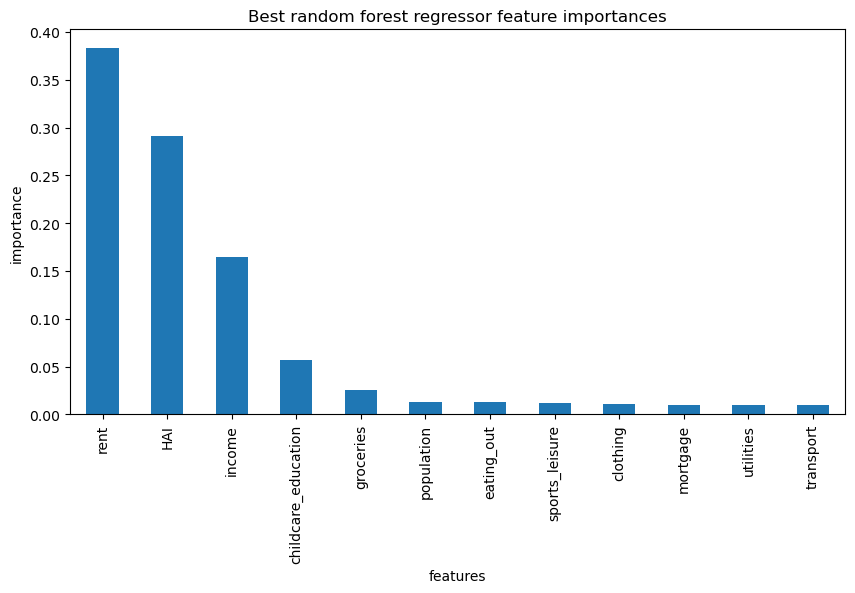

In [343]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances')

 The dominant top four features are in common with your linear model:
* rent
* HAI
* income
* childcare & education cost

## 7.9 Final Model Selection<a id='7.9-Final_Model_Selection'></a>

Linear regression model performance

In [347]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [349]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(1006.959061283044, 51.516791040130016)

In [351]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

1308.75301082869

Random forest regression model performance

In [355]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [357]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(442.06701966511275, 19.245266730191148)

In [359]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

663.3267729640337

Obviously, random forest regression model's performance is better than linear regression model's

## 7.10 Prediction<a id='7.10-Prediction'></a>

In [363]:
portland_data = df[df['city'] == 'Portland']

In [365]:
portland_data.T

,173
city,Portland
country,United States
eating_out,15.375
groceries,6.048947
transport,6782.2575
utilities,93.25
sports_leisure,30.84
childcare_education,9886.605
clothing,86.0125
rent,2224.445


In [411]:
X = df.loc[:, X_train.columns]
y = df.loc[:, 'house_price']

In [413]:
rf_grid_cv.best_estimator_.fit(X, y)

Pipeline(steps=[('standardscaler', None),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=615, random_state=47))])

In [415]:
cv_results = cross_validate(rf_grid_cv.best_estimator_, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [417]:
cv_results['test_score']

array([-944.23686105, -465.86118981, -395.29883657, -294.29080372,
       -304.19635399])

In [419]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(480.7768090268076, 240.11741568113257)

In [421]:
X_pl = df.loc[df.city == "Portland", X_train.columns]
y_pl = df.loc[df.city == "Portland", 'house_price']

In [427]:
pl_pred = rf_grid_cv.best_estimator_.predict(X_pl).item()

In [429]:
pl_pred

4475.8934308943335

In [431]:
y_pl = y_pl.values.item()

In [433]:
y_pl

4295.1

In [435]:
print(f'Portland house modelled price is ${pl_pred:.2f}, actual price is ${y_pl:.2f}.')

Portland house modelled price is $4475.89, actual price is $4295.10.


Considering the presence of MAE, this price is relatively reasonable.